# Ch.04 機械学習モデル開発の重要ポイント

## 4.3 アルゴリズム選択

In [84]:
# 共通事前処理

# データフレーム表示用関数
from IPython.display import display
# ライブラリーのインポート
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings("ignore")

# 表示オプション
# NumPyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)
# pandasの浮動小数点の表示精度
pd.options.display.float_format = "{:.4f}".format
# データフレームのすべての項目を表示
pd.set_option("display.max_columns", None)
# グラフのスタイルの設定
plt.style.use('seaborn')
# グラフのデフォルトフォント設定
plt.rcParams["font.size"] = 14
# グラフで日本語表示が可能なフォントの設定
plt.rcParams["font.family"] = 'IPAexGothic'
# 乱数の種
RANDOM_SEED = 123

### 4.3.1 分類の代表的なアルゴリズムとその特徴

|アルゴリズム名|実装方式|特徴|
|:-:|:-:|:-:|
|ロジスティック回帰|損失関数型|「シグモイド関数」の出力を確率とみなす。境界線は直線|
|サポートベクターマシン<br>（カーネル）|損失関数型|カーネルトリックという方法で、直線以外の境界を実現|
|ニューラルネットワーク|損失関数型|隠れそうを追加することで、直線以外の境界線を実現|
|決定木|決定木型|特定の項目値を規準にしたグループ分けを複数回実施|
|ランダムフォレスト|決定木型|学習データのサブセットから複数の決定木を作り、多数決で決定|
|XGBoost|決定木型|分類がうまくいかなかったデータから分類するモデル作り、精度が向上|

- 正規化
  - 損失関数には有効
  - 決定木には不要

- 単純ベイズ
  - スパムメールの分類など、テキスト系データの分類に利用されることが多い
- k近傍法
  - 近くの点を調べ、一番多いクラスに自分を分類する

### 4.3.2 サンプルコードで用いるデータ

In [85]:
# サンプルデータの生成

# ライブラリインポート
from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.datasets import make_classification

# 線形分類型
X1, y1 = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=RANDOM_SEED,
    n_clusters_per_class=1, n_samples=200, n_classes=2
)

# 三日月型（線形分離不可）
X2, y2 = make_moons(
    noise=0.05, random_state=RANDOM_SEED, n_samples=200
)

# 円形（線形分離不可）
X3, y3 = make_circles(
    noise=0.02, random_state=RANDOM_SEED, n_samples=200
)

# 3種類のデータをDataListに保存
DataList = [(X1, y1), (X2, y2), (X3, y3)]

# N: データの種類数
N = len(DataList)

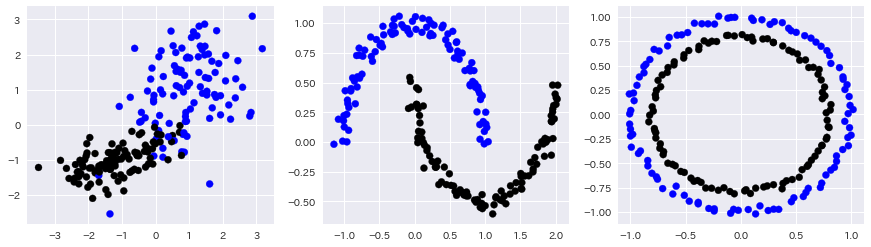

In [86]:
# 散布図表示
plt.figure(figsize=(15, 4))

# カラーマップ定義
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['#0000FF', '#000000'])

for i, data in enumerate(DataList):
    X, y = data
    ax = plt.subplot(1, N, i+1)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap)

plt.show()

散布図・分類結果表示関数

- 3種類のサンプルデータは、それぞれ青・黒100個ずつの2次元の点から構成される。
- 表示関数は、まず100個ずつの点を訓練用と検証用の50個ずつに分割する。
  - （3.3.4 「データの分割」）
- 訓練データは「x」で、検証データは「o」で散布図を表示する。
- 選択したアルゴリズムは、表示関数呼び出し時に引数として渡される。
  - （3.3.5「アルゴリズム選択」）
- 引数で渡されたアルゴリズムを使用して、「学習」、「予測」、「評価」を表示関数の内部ですべて実行する。
  - （3.3.6 ~ 3.3.8）
- 評価の結果得られる精度は、訓練データに対するものと検証データに対するものを個別に求める。
- 評価結果は、「訓練: 0.92 検証: 0.91」の形式で表示する。
- それぞれの地点（x, y）がどちらの分類先に該当するかを青・グレーで色分けして表示する。
- 各点でのモデルの確信度の大きさを濃淡で表現する。
  - 濃い部分は確信度が高い（確率値が「0」または「1」に近い）こと。
  - 薄い部分は確信度が低い（確率値が「0.5」に近い）こと。
- 決定境界で表示できるアルゴリズムでは、決定境界を太線で表示する。

In [87]:
from sklearn.model_selection import train_test_split

# 決定境界の表示関数
def plot_boundary(ax, x, y, algorithm):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.5, random_state=RANDOM_SEED
    )

    # カラーマップ定義
    from matplotlib.colors import ListedColormap
    cmap1 = plt.cm.bwr
    cmap2 = ListedColormap(['#0000FF', '#333333'])

    h = 0.05
    algorithm.fit(x_train, y_train)
    score_train = algorithm.score(x_train, y_train)
    score_test = algorithm.score(x_test, y_test)

    f1_min = x[:, 0].min() - 0.5
    f1_max = x[:, 0].max() + 0.5
    f2_min = x[:, 0].min() - 0.5
    f2_max = x[:, 0].max() + 0.5
    f1, f2 = np.meshgrid(
        np.arange(f1_min, f1_max, h), np.arange(f2_min, f2_max, h)
    )

    if hasattr(algorithm, "decision_function"):
        Z = algorithm.decision_function(np.c_[f1.ravel(), f2.ravel()])
        Z = Z.reshape(f1.shape)
        ax.contour(f1, f2, Z, levels=[0], linewidth=2)
    else:
        Z = algorithm.predict_proba(np.c_[f1.ravel(), f2.ravel()])[:, 1]
        Z =Z.reshape(f1.shape)

    ax.contourf(f1, f2, Z, cmap=cmap1, alpha=0.3)
    ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=cmap2, marker='x')
    ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=cmap2)

    text = f"訓練: {score_train:.2f} 検証: {score_test:.2f}"
    ax.text(
        f1.max() - 0.3, f2.min() + 0.3, text, 
        horizontalalignment='right', fontsize=18
    )

In [88]:
# 散布図と決定境界の表示関数

def plot_boundaries(algorithm, DataList):
    plt.figure(figsize=(15, 4))
    for i, data in enumerate(DataList):
        X, y = data
        ax = plt.subplot(1, N, i+1)
        plot_boundary(ax, X, y, algorithm)
    plt.show()

### 4.3.3 ロジスティック回帰

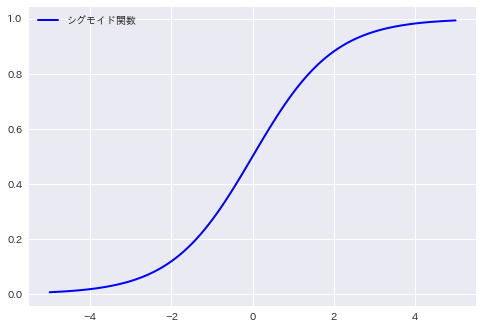

In [89]:
# シグモイド関数の定義
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# xのデータ準備
x = np.linspace(-5, 5, 101)

# yのデータ準備
y = sigmoid(x)

# グラフ表示
plt.plot(x, y, label='シグモイド関数', c='b', lw=2)

# 凡例表示
plt.legend()

# グラフ描画
plt.show()

- 値が単調に増えている。（単調関数）
- 値が「0」から「1」の間を取っている。
- グラフは点対称な形になっていて、対象の中心は、（x=0, y=0.5）の点。

In [90]:
# ロジスティック回帰の散布図・分類結果表示

# アルゴリズムの選択
from sklearn.linear_model import LogisticRegression
algorithm = LogisticRegression(random_state=RANDOM_SEED)

# アルゴリズムが持つパラメーターの表示
print(algorithm.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 123, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


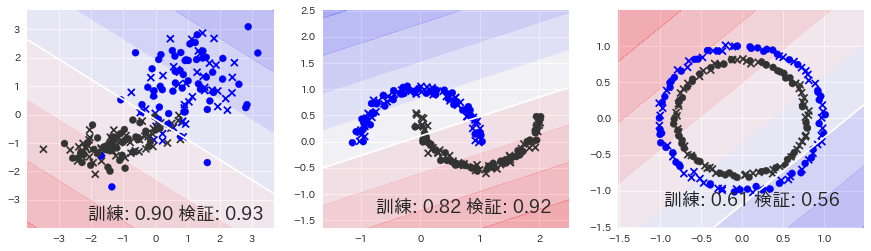

In [91]:
# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

### 4.3.4 サポートベクターマシン（ガウスカーネル法）

- ガウスカーネル
- 多項式カーネル
- シグモイドカーネル

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


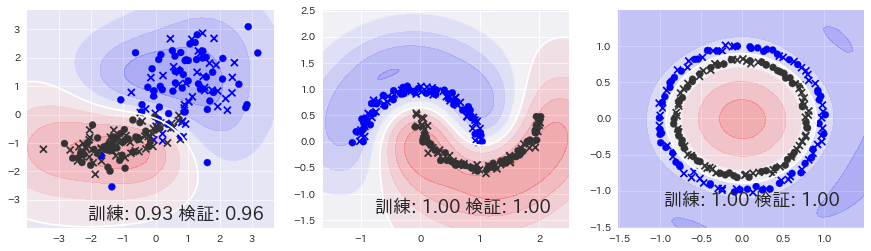

In [92]:
# SVM（ガウスカーネル）の散布図・分類結果表示

# アルゴリズム選択
from sklearn.svm import SVC
algorithm = SVC(kernel='rbf')

# アルゴリズムの持つパラメータの表示
print(algorithm.get_params())

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

### 4.3.5 ニューラルネットワーク

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 123, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


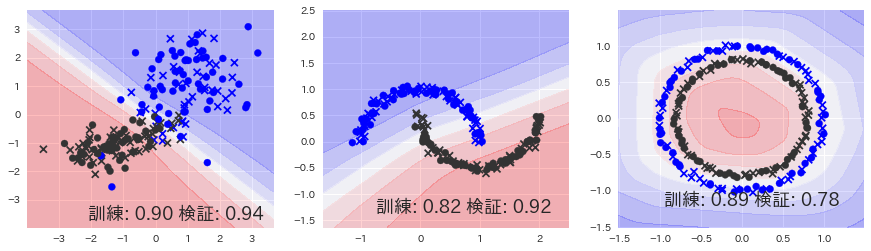

In [93]:
# ニューラルネットワークの散布図・分類結果表示

# アルゴリズムの選択
from sklearn.neural_network import MLPClassifier
algorithm = MLPClassifier(random_state=RANDOM_SEED)

# アルゴリズムの持つパラメータの表示
print(algorithm.get_params())

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 123, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


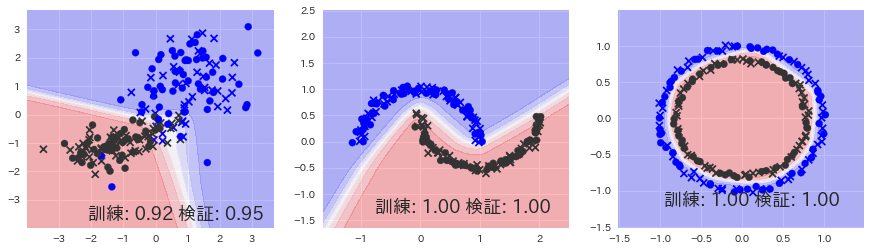

In [94]:
# ニューラルネットワークの散布図・分類結果表示

# アルゴリズムの選定
# 隠れ層ノード数=(100,100)
from sklearn.neural_network import MLPClassifier
algorithm = MLPClassifier(
    hidden_layer_sizes=(100, 100), random_state=RANDOM_SEED
)

# アルゴリズムの持つパラメータの表示
print(algorithm.get_params())

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

### 4.3.6 決定木

In [95]:
# 追加ライブラリのimport
import seaborn as sns

# サンプルデータの読み込み
df_iris = sns.load_dataset("iris")

# 2種類の花に絞り込む
df2 = df_iris[50:150]

# データ分離
X = df2.drop('species', axis=1)
y = df2['species']

In [96]:
# 学習
from sklearn.tree import DecisionTreeClassifier
algorithm = DecisionTreeClassifier(random_state=RANDOM_SEED)
algorithm.fit(X, y)

DecisionTreeClassifier(random_state=123)

In [97]:
# 決定木のツリー表示
from sklearn import tree
import pydotplus
from IPython.display import Image

with open("iris-dtree.dot", mode='w') as f:
    tree.export_graphviz(
        algorithm, out_file=f, feature_names=X.columns, filled=True,
        rounded=True, special_characters=True, impurity=False,
        proportion=False
    )

graph = pydotplus.graphviz.graph_from_dot_file("iris-dtree.dot")
graph.write_png('iris-dtree.png')
Image(graph.create_png)

FileNotFoundError: No such file or directory: '<function Dot.__init__.<locals>.<lambda> at 0x13ae400d0>'

FileNotFoundError: No such file or directory: '<function Dot.__init__.<locals>.<lambda> at 0x13ae400d0>'

<IPython.core.display.Image object>

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 123, 'splitter': 'best'}


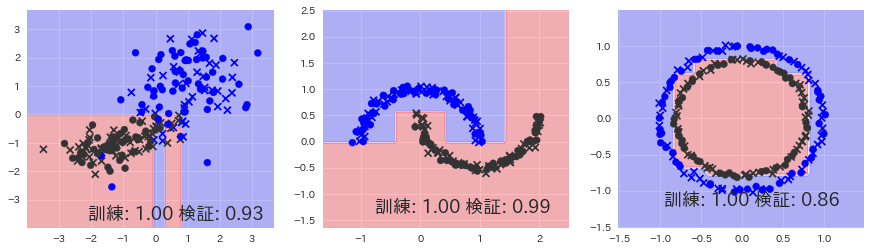

In [100]:
# 決定木の散布図・分類結果表示
from sklearn.tree import DecisionTreeClassifier

# アルゴリズムの選定
algorithm = DecisionTreeClassifier(random_state=RANDOM_SEED)

# アルゴリズムの持つパラメータの表示
print(algorithm.get_params())

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 123, 'splitter': 'best'}


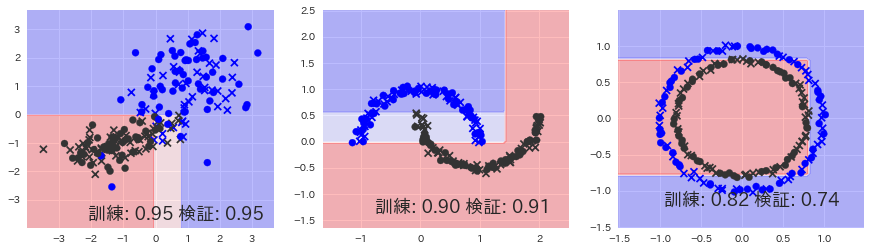

In [101]:
# 決定木の散布図・分類結果表示(max_depth=3の場合)

# アルゴリズムの選定
from sklearn.tree import DecisionTreeClassifier
algorithm = DecisionTreeClassifier(
    max_depth=3, random_state=RANDOM_SEED
)

# アルゴリズムの持つパラメータの表示
print(algorithm.get_params())

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

### 4.3.7 ランダムフォレスト

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}


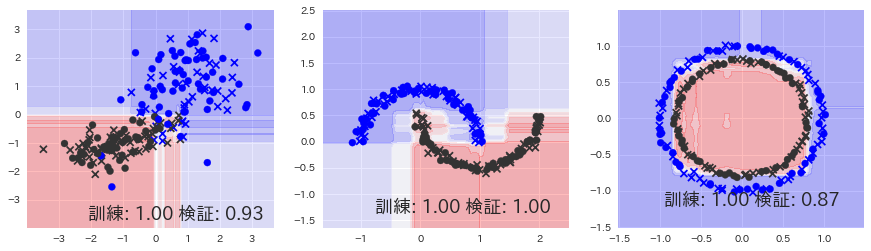

In [102]:
# ランダムフォレストの散布図・分類結果表示

# アルゴリズムの選定
from sklearn.ensemble import RandomForestClassifier
algorithm = RandomForestClassifier(random_state=RANDOM_SEED)

# アルゴリズムの持つパラメータの表示
print(algorithm.get_params())

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

### 4.3.8 XGBoost

- eXtreme Gradient Boosting

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=123,
              reg_alpha=None, reg_lambda=None, ...)>


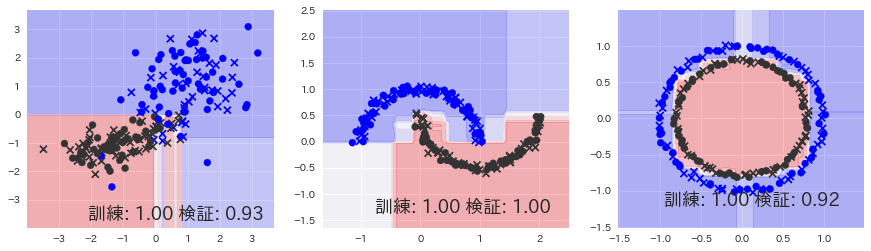

In [103]:
# XGBoostの散布図・分類結果表示

# アルゴリズムの選定
import xgboost
algorithm = xgboost.XGBClassifier(random_state=RANDOM_SEED)

# アルゴリズムの持つパラメータの表示
print(algorithm.get_params)

# 表示関数の呼び出し
plot_boundaries(algorithm, DataList)

### 4.3.9 アルゴリズムの選択方法

- モデルの判断根拠を知りたい
- 高精度のモデル
- 学習時間

|アルゴリズム名|実装方式|精度|説明性|学習時間|
|:-:|:-:|:-:|:-:|:-:|
|ロジスティック回帰|損失関数型|△|あり|速い|
|サポートベクターマシン<br>（カーネル）|損失関数型|○|なし|遅い|
|ニューラルネットワーク|損失関数型|◎|なし|遅い|
|決定木|決定木型|△|あり|速い|
|ランダムフォレスト|決定木型|○|なし|遅い|
|XGBoost|決定木型|◎|なし|遅い|